In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb
import pickle

In [5]:
data = pd.read_csv("data/diabetes.pssm.trn.csv", header=None)
print(data.shape)
print(data.columns)
data.head(3)

(3921, 401)
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            391, 392, 393, 394, 395, 396, 397, 398, 399, 400],
           dtype='int64', length=401)


0         1         2         3         4         5         6    \
0  0.219027 -0.126106 -0.117257 -0.132743  0.000000 -0.095133 -0.090708   
1  0.113615 -0.086385 -0.070423 -0.068545 -0.081690 -0.057277 -0.054460   
2  0.254777 -0.152866 -0.101911 -0.108280 -0.063694 -0.057325 -0.082803   

        7         8         9   ...        391       392       393       394  \
0 -0.048673 -0.126106 -0.066372 ...  -0.121681  0.015487 -0.042035 -0.095133   
1 -0.015023 -0.051643 -0.044131 ...  -0.106103  0.026291 -0.072300 -0.116432   
2 -0.025478 -0.184713 -0.095541 ...  -0.101911  0.012739  0.000000 -0.038217   

        395       396       397       398       399  400  
0 -0.092920 -0.015487 -0.137168 -0.073009  0.163717    1  
1 -0.093897 -0.010329 -0.162441 -0.082629  0.184038    1  
2 -0.044586 -0.025478 -0.133758 -0.038217  0.101911    1  

[3 rows x 401 columns]

In [6]:
data_cols = data.columns[:-1]

print(data_cols)
print('# of data columns: ',len(data_cols))

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            390, 391, 392, 393, 394, 395, 396, 397, 398, 399],
           dtype='int64', length=400)
# of data columns:  400


In [7]:
data.groupby(400)[400].count()
940/(940+2981)

0.23973476154042336

In [8]:
test = data[400]
test = [0 if t > 1 else 1 for t in test]
data[400] = test

In [9]:
data.skew()

0       1.819574
1     -48.408024
2      -1.543671
3      -1.580725
4      -1.159053
5     -49.425174
6      -1.480438
7      -1.786298
8      -1.410343
9      -1.413301
10     -1.561028
11     44.815346
12     -1.583891
13     -1.569076
14     -5.271191
15     57.533294
16      2.444987
17     -1.320030
18     -1.430489
19     20.711415
20     -1.198796
21      1.265393
22     -3.052605
23     -1.361574
24     -0.862004
25    -28.500986
26     -4.602865
27     -0.878841
28     -3.782945
29     -1.093480
         ...    
371    54.646979
372   -26.010836
373     2.362090
374    -1.476354
375     4.991700
376    -1.648468
377    -0.561278
378     3.011385
379    -1.337221
380    -2.838834
381    -1.113766
382    -0.985042
383    -0.883436
384    53.895201
385    -0.981104
386    -0.932540
387    -0.837892
388    -1.028537
389     1.309246
390    30.590625
391    -0.945109
392    15.880948
393    -0.972778
394    -0.902209
395    -1.171960
396     4.519782
397    -0.990418
398    -1.1884

In [10]:
# Center and scale all data, only using the middle 99.8%, so outliers don't pull too much.
# First generate the percentile data for each feature

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles

0         1         2         3         4         5         6    \
min    0.000000 -0.415359 -0.402059 -0.534476 -0.374003 -0.334415 -0.367152   
max    0.838849  0.009590  0.014824  0.010725  0.093360  0.040856  0.064663   
mean   0.208132 -0.108433 -0.099159 -0.120530 -0.073265 -0.070422 -0.075858   
stdev  0.099928  0.059385  0.058790  0.067096  0.055831  0.050437  0.054646   

            7         8         9      ...          390       391       392  \
min   -8.218009 -0.491761 -0.414723    ...    -0.068358 -0.431255 -0.135074   
max    0.870695  0.016551  0.024129    ...     0.504725  0.003598  4.304143   
mean  -0.033383 -0.124179 -0.101687    ...     0.032724 -0.138223  0.023056   
stdev  0.136562  0.066873  0.056167    ...     0.028984  0.068525  0.070197   

            393       394       395       396       397       398       399  
min   -0.260205 -0.491434 -0.357012 -7.574177 -0.517046 -0.341872  0.000000  
max    0.066224  0.036189  0.008207  8.609647  0.000000  0.010272  0.633866  
mean  -0.058930 -0.146932 -0.094561 -0.015892 -0.176935 -0.097028  0.193675  
stdev  0.041217  0.075594  0.054562  0.413263  0.073679  0.049913  0.081522  

[4 rows x 400 columns]

In [11]:
# Center and scale the data using the percentile data

data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]


In [12]:
data

0         1         2         3         4         5         6    \
0     0.109032 -0.297592 -0.307835 -0.182028  1.312275 -0.489931 -0.271758   
1    -0.945844  0.371276  0.488792  0.774785 -0.150901  0.260632  0.391571   
2     0.466789 -0.748207 -0.046806  0.182570  0.171431  0.259680 -0.127099   
3     3.854288 -3.200678 -3.073493 -1.762802 -3.165554 -3.042592 -2.230801   
4    -0.309388 -0.518757 -0.251142 -0.090204  1.312275  0.141393 -0.696605   
5    -0.668685  0.175420  0.489949  0.586486  0.127513  0.049040  0.287775   
6    -2.082809  1.825926  1.686659  1.796386  1.312275  1.396251  1.388175   
7    -0.930823  0.905650  1.073514  1.033848  0.979034  0.589340  0.622148   
8     0.955079 -1.381528 -0.945780 -0.155335 -0.926640 -0.846060 -0.681435   
9    -0.096365 -0.255309  1.113299  0.289224 -0.968570  0.356653  1.045476   
10   -0.632489 -0.126439  0.454075  1.148386  0.014349 -0.615157  0.194721   
11   -0.011234  0.098213 -0.064683  0.304903 -0.713101  0.221533  0.237835   
12    0.614775 -0.663338  0.059657 -0.018024  0.377770 -0.155414 -0.362232   
13    1.790939 -1.795401 -0.325236 -2.049840  0.349308 -1.588435 -0.776319   
14    0.737393 -0.470328  0.140333 -0.100503  0.335302  0.314799 -0.275436   
15   -0.635992  0.608641  0.866915  0.718984 -0.090414  0.918505  0.726731   
16   -0.594752 -0.114651  0.042613  0.411244  0.313504  0.216953  0.435765   
17    1.080079 -0.268056 -0.340392 -0.288637 -1.007850  0.060758 -0.034081   
18   -0.353629  0.897298  0.498487  0.700503 -0.004727  0.229960  0.580827   
19    2.032292 -1.321581 -1.015809 -1.268001 -0.696480 -1.568509 -1.690281   
20    1.028662 -1.287195 -1.029161 -0.207529 -0.945447 -1.269541 -1.072299   
21   -0.231091  0.102237  0.280356  0.505483 -0.591680  0.069264  0.451576   
22   -0.089040 -0.496715 -0.463983 -0.544869  0.282893 -0.654791 -0.575021   
23    2.137907 -2.756158 -2.478957 -0.332769 -2.343103 -2.380278 -0.852610   
24   -1.110682  1.248579  1.103468  1.370561  0.391113  1.282961  1.388175   
25    0.238135  0.811519  0.790066  0.651647 -1.142435  1.157378  0.699171   
26   -0.143919  1.299703  0.729869  0.958031 -0.478857  1.148416  1.388175   
27    0.037351 -0.212706 -0.207870 -0.007978  0.314793 -0.404002  0.103204   
28    0.776381 -1.839738 -1.900392 -1.954990 -1.490184 -1.301264 -1.475058   
29    1.526339 -2.222829 -1.752443 -1.217014 -1.134626 -2.937470 -2.211769   
...        ...       ...       ...       ...       ...       ...       ...   
3891 -0.689190  0.045944 -0.196950  0.095918 -0.310562 -0.167270 -0.300562   
3892  0.946393 -1.769468 -1.485392 -0.378807 -2.076349 -0.961532 -0.540709   
3893 -0.387904  0.612295  0.675285  0.265691 -0.688634  0.646045 -0.029634   
3894 -0.609893  0.367993  0.557596  0.161884  0.381818 -0.120082 -0.222623   
3895 -0.315492  0.165182  0.204170  0.053024  1.353363  0.532239  0.045084   
3896 -0.918264  0.298110  0.613081  0.208966  0.782350  0.379494  0.016591   
3897 -0.254869  0.261923  0.633425 -0.233895  0.868647 -0.015555 -0.028207   
3898 -0.718191  0.380134  0.827589  0.290923  0.769508  0.194628 -0.183023   
3899 -0.227619 -0.475497  0.167532 -0.038890  0.342789 -0.374480 -0.394751   
3900 -0.326680  0.981628  0.881186  0.779256 -0.059768  1.230559  1.184279   
3901  4.279373 -1.965678 -2.819200 -2.842633 -3.906922  1.527564 -3.217066   
3902 -0.144529 -0.372880  0.224463  0.012440  0.474204 -0.415997 -0.165016   
3903 -0.236826  0.681521  0.860945  0.638785  0.268905  1.203753  1.210503   
3904  0.113886  0.319984  0.442050  0.463498  0.438561  0.429100  0.941844   
3905 -0.447867  0.976576  0.623559  0.946584  0.487405  0.831009  0.846411   
3906  0.448836 -0.143328  0.428187  0.658130 -0.867855  0.686452  0.995097   
3907  0.325267  0.510873  0.682276  0.746005 -2.520174  1.106721  0.760750   
3908 -0.541854  0.880257  0.454075  0.797379 -0.115436  0.965237  1.156116   
3909 -0.377036  0.513786  0.361237  0.175327  0.032887  0.237534  0.526660   
3910 -0.292836 -0.280921  0.11024

In [13]:
data.skew()

0       1.819574
1     -48.408024
2      -1.543671
3      -1.580725
4      -1.159053
5     -49.425174
6      -1.480438
7      -1.786298
8      -1.410343
9      -1.413301
10     -1.561028
11     44.815346
12     -1.583891
13     -1.569076
14     -5.271191
15     57.533294
16      2.444987
17     -1.320030
18     -1.430489
19     20.711415
20     -1.198796
21      1.265393
22     -3.052605
23     -1.361574
24     -0.862004
25    -28.500986
26     -4.602865
27     -0.878841
28     -3.782945
29     -1.093480
         ...    
371    54.646979
372   -26.010836
373     2.362090
374    -1.476354
375     4.991700
376    -1.648468
377    -0.561278
378     3.011385
379    -1.337221
380    -2.838834
381    -1.113766
382    -0.985042
383    -0.883436
384    53.895201
385    -0.981104
386    -0.932540
387    -0.837892
388    -1.028537
389     1.309246
390    30.590625
391    -0.945109
392    15.880948
393    -0.972778
394    -0.902209
395    -1.171960
396     4.519782
397    -0.990418
398    -1.1884

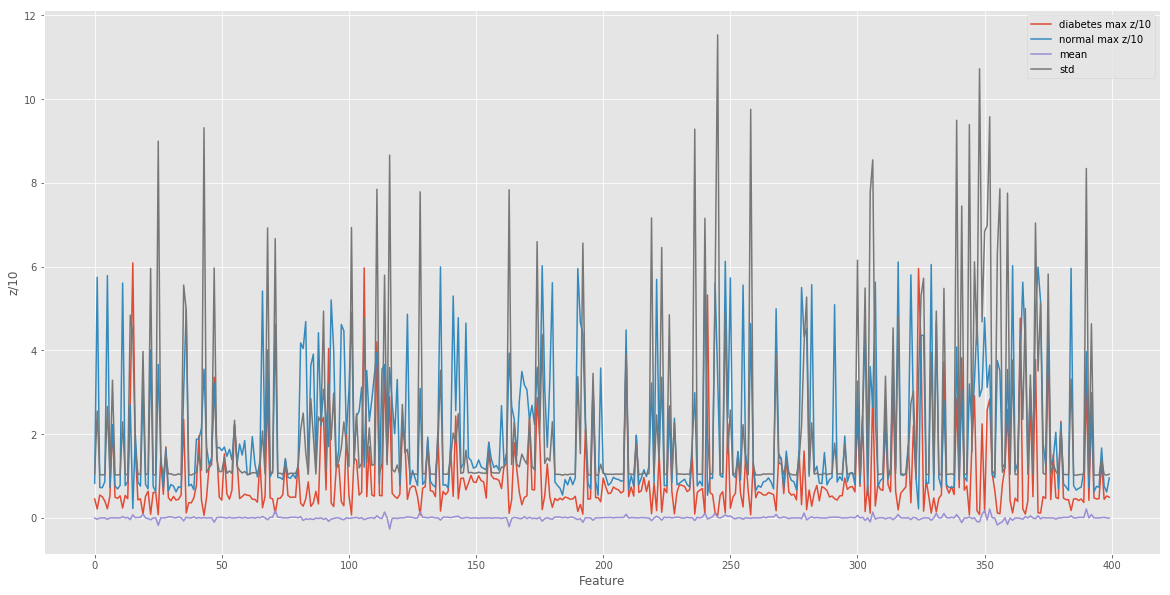

In [14]:
plot_cols = data_cols
plt.figure(figsize=(20,10))
# plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
# plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
plt.plot( data.loc[ data[400]==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values/10 , label='diabetes max z/10' )
plt.plot( data.loc[ data[400]==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values/10 , label='normal max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')

plt.legend() ; 

In [15]:
data.groupby(400)[400].count()

400
0    2981
1     940
Name: 400, dtype: int64

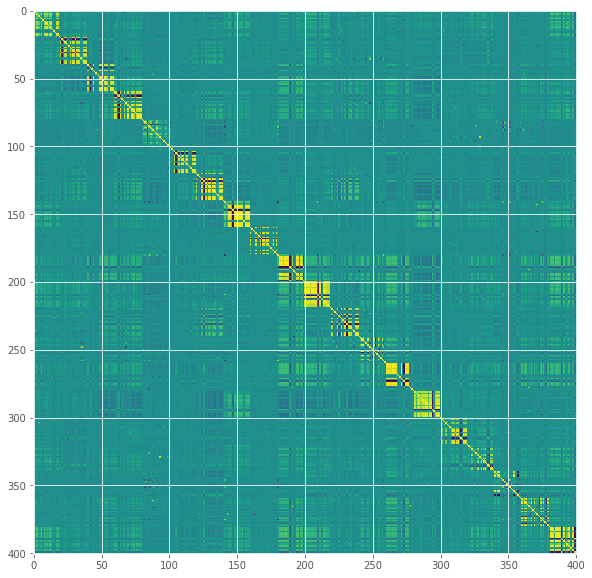

In [16]:
corr0 = data.corr()
plt.figure(figsize=(10,10))
plt.imshow(corr0) ;

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


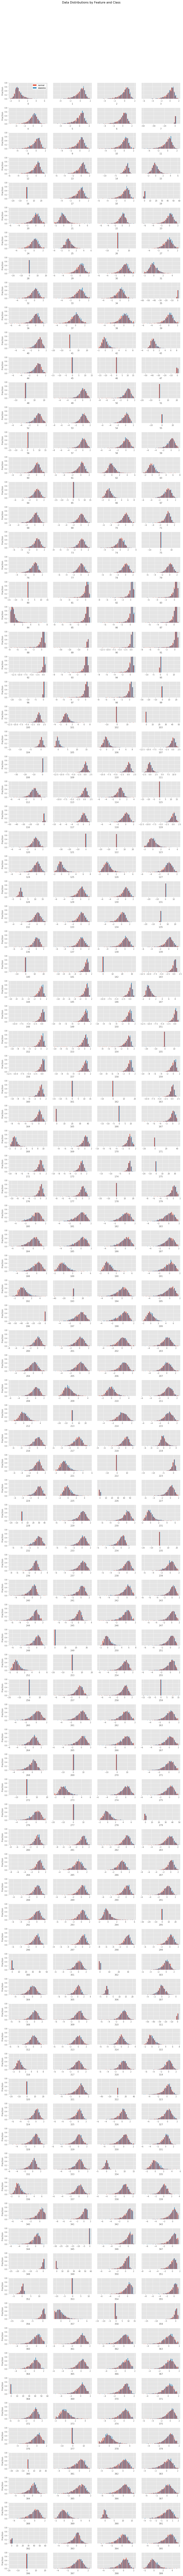

In [17]:
# Plot the data by each feature

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data[400] == 0, col ], data.loc[ data[400] == 1, col ] ], label=['normal','diabetes'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.savefig('Data_Distributions.png')
plt.show()

In [18]:
pickle.dump(data, open('data/' + 'diabetes.engineered.pkl','wb'))

In [19]:
test_cols = data.columns

# test_cols = data.columns[ data.columns != 'Amount' ]

print(len(test_cols))
print(test_cols)

401
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            391, 392, 393, 394, 395, 396, 397, 398, 399, 400],
           dtype='int64', length=401)


<h2>Try classification with XGBoost</h2>

In [20]:
# Define some custom metric functions for use with the xgboost algorithm
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

In [21]:
np.random.seed(42)

n_normal = np.sum(data[400]==0) # 2981
n_diabetes = np.sum(data[400]==1) # 940
train_fraction = 0.7
fn_normal = int(n_normal * train_fraction)
fn_diabetes = int(n_diabetes * train_fraction)

normal_samples = data.loc[ data[400]==0, test_cols].sample(n_normal, replace=False).reset_index(drop=True)
diabetes_samples = data.loc[ data[400]==1, test_cols].sample(n_diabetes, replace=False).reset_index(drop=True)

train_df = pd.concat([normal_samples[:fn_normal],diabetes_samples[:fn_diabetes]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([normal_samples[fn_normal:],diabetes_samples[fn_diabetes:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_normal, n_diabetes )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col])
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col])


classes 0, 1:  2981 940
train, test:  2744 1177


In [22]:
def BaseMetrics(y_pred,y_true):
    TP = np.sum( (y_pred == 1) & (y_true == 1) )
    TN = np.sum( (y_pred == 0) & (y_true == 0) )
    FP = np.sum( (y_pred == 1) & (y_true == 0) )
    FN = np.sum( (y_pred == 0) & (y_true == 1) )
    return TP, TN, FP, FN

def SimpleMetrics(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    
    # Reporting
    from IPython.display import display
    print( 'Confusion Matrix')
    display( pd.DataFrame( [[TN,FP],[FN,TP]], columns=['Pred 0','Pred 1'], index=['True 0', 'True 1'] ) )
    print( 'Accuracy : {}'.format( ACC ))
    
def SimpleAccuracy(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    return ACC

In [23]:

# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=3000, 
                     verbose_eval=False,
                     early_stopping_rounds=50, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df[400].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

[11:50:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[11:50:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[11:50:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[11:50:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[11:50:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[11:50:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[11:50:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[11:50:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[11:50:50] /wor

Pred 0  Pred 1
True 0     849      46
True 1     247      35

Accuracy : 0.7510620220900595


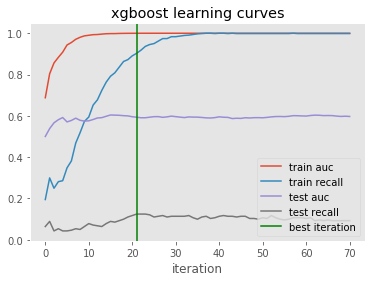

In [24]:
for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

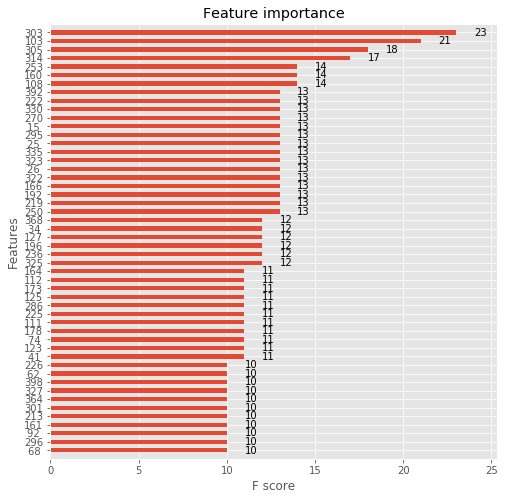

In [25]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=50, height=0.5, ax=ax);

In [26]:
import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

# print( 'Top eight features for fraud detection: ', [ i[0] for i in sorted_x[:8] ] )

sorted_cols = [i[0] for i in sorted_x] + ['Class']
print( sorted_cols )

['303', '103', '305', '314', '108', '160', '253', '250', '219', '192', '166', '322', '26 ', '323', '335', '25 ', '295', '15 ', '270', '330', '222', '392', '325', '236', '196', '127', '34 ', '368', '41 ', '123', '74 ', '178', '111', '225', '286', '125', '173', '112', '164', '272', '68 ', '296', '92 ', '161', '213', '301', '364', '327', '398', '62 ', '226', '344', '308', '352', '155', '102', '117', '193', '48 ', '208', '97 ', '84 ', '43 ', '19 ', '140', '116', '321', '58 ', '171', '348', '16 ', '137', '47 ', '304', '306', '329', '200', '256', '277', '128', '268', '292', '44 ', '269', '287', '217', '212', '326', '339', '350', '122', '320', '209', '307', '100', '353', '101', '35 ', '228', '37 ', '4  ', '244', '99 ', '198', '396', '380', '120', '56 ', '245', '174', '28 ', '22 ', '51 ', '23 ', '7  ', '377', '78 ', '316', '373', '131', '288', '366', '163', '210', '121', '5  ', '376', '312', '370', '324', '283', '142', '24 ', '1  ', '361', '12 ', '393', '313', '57 ', '89 ', '107', '384', '280'

<h1>Classification using NN</h1>

In [27]:
np.random.seed(42)

n_normal = np.sum(data[400]==0) # 2981
n_diabetes = np.sum(data[400]==1) # 940
train_fraction = 0.8
fn_normal = int(n_normal * train_fraction)
fn_diabetes = int(n_diabetes * train_fraction)

normal_samples = data.loc[ data[400]==0, test_cols].sample(n_normal, replace=False).reset_index(drop=True)
diabetes_samples = data.loc[ data[400]==1, test_cols].sample(n_diabetes, replace=False).reset_index(drop=True)

train_df = pd.concat([normal_samples[:fn_normal],diabetes_samples[:fn_diabetes]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([normal_samples[fn_normal:],diabetes_samples[fn_diabetes:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_normal, n_diabetes )
print( 'train, test: ', len(train_df), len(test_df) )
print(train_df.shape[1])

classes 0, 1:  2981 940
train, test:  3136 785
401


In [28]:
print(train_df.values[:,:399].shape)
X_train = train_df.values[:,:400]
y_train = train_df.values[:,400]
X_test = test_df.values[:,:400]
y_test = test_df.values[:,400]

(3136, 399)


In [29]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [30]:
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

Using TensorFlow backend.


In [31]:
inputs = layers.Input((train_df.shape[1]-1,))
base_n_count = 128
#activation = layers.ELU()
#activation.__name__ = 'ELU'
#x = layers.Dropout(0.3)(x)
x = layers.Dense(base_n_count, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(base_n_count*4, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
#x = layers.Dense(base_n_count*8, activation='relu')(x)
#x = layers.Dense(base_n_count*4, activation='relu')(x)
#x = layers.Dense(base_n_count*2, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
#x = layers.Dense(base_n_count, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)
#x = layers.Dense(1)(x)
classify_model = models.Model(inputs=[inputs], outputs=[x], name='classification_model')
adadelta = optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=None, decay=0.01)
classify_model.compile(optimizer=adadelta, loss='binary_crossentropy', metrics=[auc])
classify_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               51328     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________


In [32]:
#classify_model = models.load_model('model-nn.h5', custom_objects={'auc': auc})

earlystopper = EarlyStopping(patience=25, verbose=1)
checkpointer = ModelCheckpoint('model-nn-3.h5', verbose=1, save_best_only=True)

results = classify_model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=300, 
                    callbacks=[earlystopper, checkpointer])

Train on 2508 samples, validate on 628 samples
Epoch 1/300
2508/2508 [==============================] - 1s 365us/step - loss: 0.6586 - auc: 0.5234 - val_loss: 0.6322 - val_auc: 0.5252

Epoch 00001: val_loss improved from inf to 0.63220, saving model to model-nn-3.h5
Epoch 2/300
2508/2508 [==============================] - 0s 152us/step - loss: 0.6230 - auc: 0.5261 - val_loss: 0.6251 - val_auc: 0.5322

Epoch 00002: val_loss improved from 0.63220 to 0.62514, saving model to model-nn-3.h5
Epoch 3/300
2508/2508 [==============================] - 0s 152us/step - loss: 0.6161 - auc: 0.5339 - val_loss: 0.6229 - val_auc: 0.5367

Epoch 00003: val_loss improved from 0.62514 to 0.62289, saving model to model-nn-3.h5
Epoch 4/300
2508/2508 [==============================] - 0s 131us/step - loss: 0.6190 - auc: 0.5371 - val_loss: 0.6206 - val_auc: 0.5386

Epoch 00004: val_loss improved from 0.62289 to 0.62063, saving model to model-nn-3.h5
Epoch 5/300
2508/2508 [==============================] - 0s 1

2508/2508 [==============================] - 0s 85us/step - loss: 0.5734 - auc: 0.5796 - val_loss: 0.6046 - val_auc: 0.5800

Epoch 00038: val_loss did not improve from 0.60439
Epoch 39/300
2508/2508 [==============================] - 0s 87us/step - loss: 0.5746 - auc: 0.5802 - val_loss: 0.6042 - val_auc: 0.5805

Epoch 00039: val_loss improved from 0.60439 to 0.60417, saving model to model-nn-3.h5
Epoch 40/300
2508/2508 [==============================] - 0s 85us/step - loss: 0.5874 - auc: 0.5808 - val_loss: 0.6040 - val_auc: 0.5808

Epoch 00040: val_loss improved from 0.60417 to 0.60396, saving model to model-nn-3.h5
Epoch 41/300
2508/2508 [==============================] - 0s 100us/step - loss: 0.5644 - auc: 0.5811 - val_loss: 0.6040 - val_auc: 0.5814

Epoch 00041: val_loss did not improve from 0.60396
Epoch 42/300
2508/2508 [==============================] - 0s 87us/step - loss: 0.5815 - auc: 0.5816 - val_loss: 0.6040 - val_auc: 0.5819

Epoch 00042: val_loss did not improve from 0.603

2508/2508 [==============================] - 0s 81us/step - loss: 0.5558 - auc: 0.5913 - val_loss: 0.6004 - val_auc: 0.5914

Epoch 00077: val_loss did not improve from 0.60027
Epoch 78/300
2508/2508 [==============================] - 0s 81us/step - loss: 0.5568 - auc: 0.5916 - val_loss: 0.6004 - val_auc: 0.5919

Epoch 00078: val_loss did not improve from 0.60027
Epoch 79/300
2508/2508 [==============================] - 0s 91us/step - loss: 0.5522 - auc: 0.5920 - val_loss: 0.6003 - val_auc: 0.5922

Epoch 00079: val_loss did not improve from 0.60027
Epoch 80/300
2508/2508 [==============================] - 0s 93us/step - loss: 0.5662 - auc: 0.5923 - val_loss: 0.6003 - val_auc: 0.5924

Epoch 00080: val_loss improved from 0.60027 to 0.60026, saving model to model-nn-3.h5
Epoch 81/300
2508/2508 [==============================] - 0s 115us/step - loss: 0.5651 - auc: 0.5925 - val_loss: 0.6002 - val_auc: 0.5926

Epoch 00081: val_loss improved from 0.60026 to 0.60021, saving model to model-nn-3.

2508/2508 [==============================] - 0s 92us/step - loss: 0.5655 - auc: 0.5981 - val_loss: 0.5978 - val_auc: 0.5981

Epoch 00116: val_loss improved from 0.59787 to 0.59784, saving model to model-nn-3.h5
Epoch 117/300
2508/2508 [==============================] - 0s 81us/step - loss: 0.5515 - auc: 0.5982 - val_loss: 0.5978 - val_auc: 0.5983

Epoch 00117: val_loss improved from 0.59784 to 0.59776, saving model to model-nn-3.h5
Epoch 118/300
2508/2508 [==============================] - 0s 84us/step - loss: 0.5614 - auc: 0.5984 - val_loss: 0.5976 - val_auc: 0.5984

Epoch 00118: val_loss improved from 0.59776 to 0.59763, saving model to model-nn-3.h5
Epoch 119/300
2508/2508 [==============================] - 0s 86us/step - loss: 0.5459 - auc: 0.5985 - val_loss: 0.5976 - val_auc: 0.5986

Epoch 00119: val_loss improved from 0.59763 to 0.59758, saving model to model-nn-3.h5
Epoch 120/300
2508/2508 [==============================] - 0s 86us/step - loss: 0.5577 - auc: 0.5987 - val_loss: 0

2508/2508 [==============================] - 0s 126us/step - loss: 0.5498 - auc: 0.6027 - val_loss: 0.5964 - val_auc: 0.6028

Epoch 00155: val_loss did not improve from 0.59641
Epoch 156/300
2508/2508 [==============================] - 0s 164us/step - loss: 0.5477 - auc: 0.6029 - val_loss: 0.5964 - val_auc: 0.6030

Epoch 00156: val_loss improved from 0.59641 to 0.59636, saving model to model-nn-3.h5
Epoch 157/300
2508/2508 [==============================] - 0s 174us/step - loss: 0.5460 - auc: 0.6031 - val_loss: 0.5963 - val_auc: 0.6031

Epoch 00157: val_loss improved from 0.59636 to 0.59635, saving model to model-nn-3.h5
Epoch 158/300
2508/2508 [==============================] - 0s 122us/step - loss: 0.5485 - auc: 0.6032 - val_loss: 0.5963 - val_auc: 0.6032

Epoch 00158: val_loss improved from 0.59635 to 0.59630, saving model to model-nn-3.h5
Epoch 159/300
2508/2508 [==============================] - 0s 132us/step - loss: 0.5563 - auc: 0.6033 - val_loss: 0.5962 - val_auc: 0.6033

Epoch


Epoch 00193: val_loss improved from 0.59526 to 0.59524, saving model to model-nn-3.h5
Epoch 194/300
2508/2508 [==============================] - 0s 179us/step - loss: 0.5595 - auc: 0.6059 - val_loss: 0.5952 - val_auc: 0.6059

Epoch 00194: val_loss improved from 0.59524 to 0.59519, saving model to model-nn-3.h5
Epoch 195/300
2508/2508 [==============================] - 0s 129us/step - loss: 0.5475 - auc: 0.6059 - val_loss: 0.5952 - val_auc: 0.6060

Epoch 00195: val_loss improved from 0.59519 to 0.59517, saving model to model-nn-3.h5
Epoch 196/300
2508/2508 [==============================] - 0s 139us/step - loss: 0.5489 - auc: 0.6060 - val_loss: 0.5951 - val_auc: 0.6061

Epoch 00196: val_loss improved from 0.59517 to 0.59511, saving model to model-nn-3.h5
Epoch 197/300
2508/2508 [==============================] - 0s 149us/step - loss: 0.5572 - auc: 0.6061 - val_loss: 0.5951 - val_auc: 0.6061

Epoch 00197: val_loss improved from 0.59511 to 0.59510, saving model to model-nn-3.h5
Epoch 198

2508/2508 [==============================] - 0s 130us/step - loss: 0.5388 - auc: 0.6088 - val_loss: 0.5949 - val_auc: 0.6088

Epoch 00234: val_loss did not improve from 0.59486
Epoch 235/300
2508/2508 [==============================] - 0s 164us/step - loss: 0.5448 - auc: 0.6089 - val_loss: 0.5948 - val_auc: 0.6089

Epoch 00235: val_loss improved from 0.59486 to 0.59480, saving model to model-nn-3.h5
Epoch 236/300
2508/2508 [==============================] - 0s 170us/step - loss: 0.5587 - auc: 0.6090 - val_loss: 0.5948 - val_auc: 0.6090

Epoch 00236: val_loss did not improve from 0.59480
Epoch 237/300
2508/2508 [==============================] - 0s 128us/step - loss: 0.5410 - auc: 0.6090 - val_loss: 0.5948 - val_auc: 0.6091

Epoch 00237: val_loss improved from 0.59480 to 0.59478, saving model to model-nn-3.h5
Epoch 238/300
2508/2508 [==============================] - 0s 131us/step - loss: 0.5513 - auc: 0.6091 - val_loss: 0.5948 - val_auc: 0.6091

Epoch 00238: val_loss did not improve fr

2508/2508 [==============================] - 0s 173us/step - loss: 0.5423 - auc: 0.6113 - val_loss: 0.5944 - val_auc: 0.6113

Epoch 00274: val_loss improved from 0.59443 to 0.59438, saving model to model-nn-3.h5
Epoch 275/300
2508/2508 [==============================] - 0s 156us/step - loss: 0.5475 - auc: 0.6113 - val_loss: 0.5943 - val_auc: 0.6114

Epoch 00275: val_loss improved from 0.59438 to 0.59434, saving model to model-nn-3.h5
Epoch 276/300
2508/2508 [==============================] - 0s 163us/step - loss: 0.5488 - auc: 0.6114 - val_loss: 0.5944 - val_auc: 0.6114

Epoch 00276: val_loss did not improve from 0.59434
Epoch 277/300
2508/2508 [==============================] - 0s 161us/step - loss: 0.5582 - auc: 0.6114 - val_loss: 0.5944 - val_auc: 0.6114

Epoch 00277: val_loss did not improve from 0.59434
Epoch 278/300
2508/2508 [==============================] - 0s 152us/step - loss: 0.5545 - auc: 0.6114 - val_loss: 0.5944 - val_auc: 0.6114

Epoch 00278: val_loss did not improve fr

In [36]:
print(results.history.keys())

dict_keys(['val_loss', 'val_auc', 'loss', 'auc'])


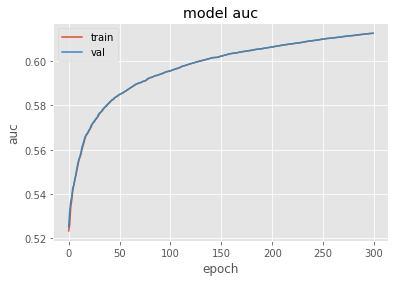

In [37]:
plt.plot(results.history['auc'])
plt.plot(results.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

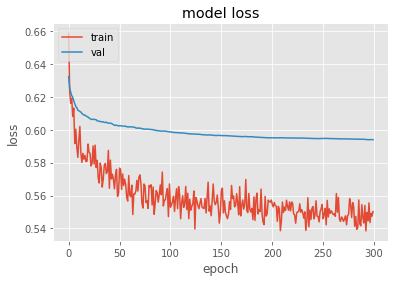

In [38]:
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
model = models.load_model('model-nn-3.h5', custom_objects={'auc': auc})

In [40]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

785/785 [==============================] - 0s 44us/step


In [41]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


print(np.mean(preds_train_t == y_train[:int(y_train.shape[0]*0.9)]))
print(np.mean(preds_val_t == y_train[int(y_train.shape[0]*0.9):]))
print(np.mean(preds_test_t == y_test))

0.7582008527711547
0.749989857600714
0.7585183983123047


In [42]:
def BaseMetrics(y_pred,y_true):
    CM = confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    return TP, TN, FP, FN

In [43]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
auc_test = auc(fpr, tpr)
print(auc_test)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train[:int(y_train.shape[0]*0.9)], preds_train)
auc_train = auc(fpr_train, tpr_train)
print(auc_train)
TP, TN, FP, FN = BaseMetrics(preds_test_t, y_test)
print("precision =", TP/(TP+FP))
print("recall = ", TP/(TP+FN))
print(np.sum((preds_test_t == 0) & (y_test == 1)))

0.5890712427385153
0.6659120484723902
precision = 0.0
recall =  0.0
147016


In [44]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0.0: 597, 1.0: 188}

In [45]:
unique, counts = np.unique(preds_test_t, return_counts=True)
dict(zip(unique, counts))

{0: 782, 1: 3}

<h2>Prepare for GAN</h2>

In [46]:
# reloading the libraries and setting the parameters
import gan
import importlib
importlib.reload(gan) # For reloading after making changes
from gan import *

rand_dim = 400 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

In [47]:
nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 32 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 0.1 # using Adadelta optimizer
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = data.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ 400 ]
data_cols = [ i for i in range(0, 400) ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

In [51]:
# Training the vanilla GAN and CGAN architectures

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

data_dim:  400
data_cols:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 21

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


FileNotFoundError: [Errno 2] No such file or directory: 'cache/WCGAN_losses_step_500.pkl'

In [ ]:
# Training the WGAN and WCGAN architectures
k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

#adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN

In [49]:
# # for continued training
'''
import gan
import importlib
importlib.reload(gan) # For reloading after making changes
from gan import *

last_step = 500
prefix = 'WCGAN'
# # data_dir = 'cache lr mix base 128 act mix 171026/'
data_dir = 'cache/'

# # Choose your learning rate
learning_rate = 1e-5 # first 10k
# # learning_rate = 1e-5 # 10-15k
# # learning_rate = 1e-6 # 15-20k

generator_model_path = data_dir + prefix + '_generator_model_weights_step_' + str(last_step) + '.h5'
discriminator_model_path = data_dir + prefix + '_discriminator_model_weights_step_' + str(last_step) + '.h5'
loss_pickle_path = data_dir + prefix + '_losses_step_' + str(last_step) + '.pkl'

nb_steps = 4000

arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
             data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

# # Choose your training algorithm
#adversarial_training_GAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # GAN
#adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # CGAN
#adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # WCGAN
'''

"\nimport gan\nimport importlib\nimportlib.reload(gan) # For reloading after making changes\nfrom gan import *\n\nlast_step = 500\nprefix = 'WCGAN'\n# # data_dir = 'cache lr mix base 128 act mix 171026/'\ndata_dir = 'cache/'\n\n# # Choose your learning rate\nlearning_rate = 1e-5 # first 10k\n# # learning_rate = 1e-5 # 10-15k\n# # learning_rate = 1e-6 # 15-20k\n\ngenerator_model_path = data_dir + prefix + '_generator_model_weights_step_' + str(last_step) + '.h5'\ndiscriminator_model_path = data_dir + prefix + '_discriminator_model_weights_step_' + str(last_step) + '.h5'\nloss_pickle_path = data_dir + prefix + '_losses_step_' + str(last_step) + '.pkl'\n\nnb_steps = 4000\n\narguments = [rand_dim, nb_steps, batch_size, \n             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,\n             data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]\n\n# # Choose your training algorithm\n#adversarial_training_GAN(arguments, train_no_l

In [50]:
last_step = 500
prefix = 'WCGAN'
# # data_dir = 'cache lr mix base 128 act mix 171026/'
data_dir = 'cache/'

# # Choose your learning rate
learning_rate = 1e-5 # first 10k
# # learning_rate = 1e-5 # 10-15k
# # learning_rate = 1e-6 # 15-20k

generator_model_path = data_dir + prefix + '_generator_model_weights_step_' + str(last_step) + '.h5'
discriminator_model_path = data_dir + prefix + '_discriminator_model_weights_step_' + str(last_step) + '.h5'
loss_pickle_path = data_dir + prefix + '_losses_step_' + str(last_step) + '.pkl'

nb_steps = 1000

arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
             data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

# # Choose your training algorithm
#adversarial_training_GAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # GAN
#adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # CGAN
#adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # WCGAN

data_dim:  400
data_cols:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 21

FileNotFoundError: [Errno 2] No such file or directory: 'cache/WCGAN_losses_step_500.pkl'

In [41]:

# For reloading loss data from pickles

prefix = 'WCGAN'
step = 500

[combined_loss, disc_loss_generated, disc_loss_real, classify_acc] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))

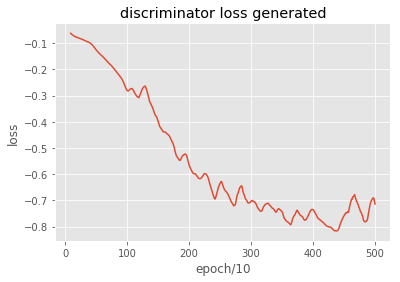

In [125]:
w = 10
plt.title('discriminator loss generated')
plt.ylabel('loss')
plt.xlabel('epoch/10')
plt.plot( pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;

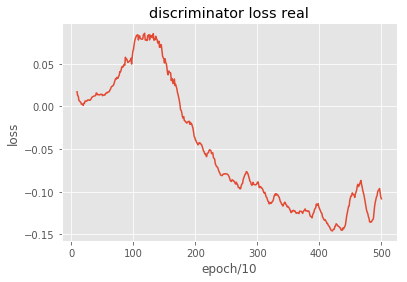

In [126]:
w = 10
plt.title('discriminator loss real')
plt.ylabel('loss')
plt.xlabel('epoch/10')
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() ) ;

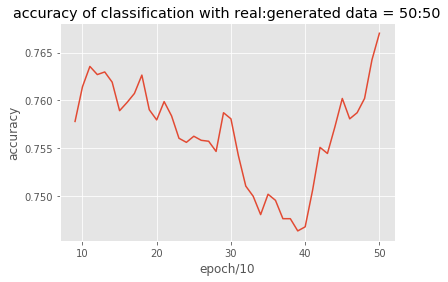

In [127]:
w = 10
plt.title('accuracy of classification with real:generated data = 50:50')
plt.ylabel('accuracy')
plt.xlabel('epoch/10')
plt.plot( pd.DataFrame(classify_acc[:]).rolling(w).mean() ) ;

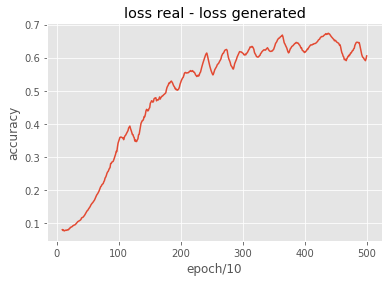

In [45]:
w = 10
plt.title('loss real - loss generated')
plt.ylabel('accuracy')
plt.xlabel('epoch/10')
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean()  ) ;

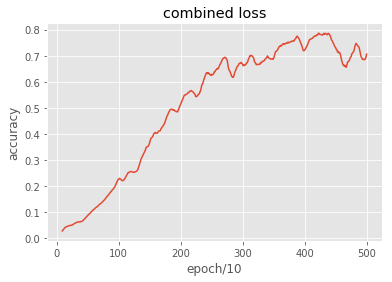

In [46]:
w = 10
plt.title('combined loss')
plt.ylabel('accuracy')
plt.xlabel('epoch/10')
plt.plot( pd.DataFrame(combined_loss[:]).rolling(w).mean() ) ;

In [128]:
# Look for the step with the highest classification accuracy, and the lowest step saved (every 100)

best_step = list(classify_acc).index( classify_acc.max() ) * 10
print( best_step, classify_acc.max() )

acc100 = [ classify_acc[i] for i in range(0, len(classify_acc), 10) ]
best_step = acc100.index( max(acc100) ) * log_interval
print( best_step, max(acc100) )

450 0.7978723404255319
500 0.7872340425531915


In [129]:
delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )

10 0.048477907
0 0.06992142


In [130]:
import gan
import importlib
importlib.reload(gan) # For reloading after making changes
from gan import *

seed = 17

train = train.copy().reset_index(drop=True) # diabetes only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ 400 ]
data_cols = [ i for i in range(0, 400) ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0: with_class = True
np.random.seed(seed)

# define network models

# generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
# generator_model.load_weights('cache/WCGAN_generator_model_weights_step_4800.h5')
generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
generator_model.load_weights('cache/WCGAN_generator_model_weights_step_500.h5')

In [142]:
# Now generate some new data

test_size = 3000 # Equal to all of the diabetes cases

x = get_data_batch(train, test_size, seed=1)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)

In [143]:
train.shape
unique, counts = np.unique(x[:,400], return_counts=True)
dict(zip(unique, counts))

{0.0: 2253, 1.0: 747}

In [144]:
# Plot the data by each feature
def plot_data_distribution(dataset):
    dataset = pd.DataFrame(dataset)
    axarr = [[]]*len(data_cols)
    columns = 4
    rows = int( np.ceil( len(data_cols) / columns ) )
    f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

    f.suptitle('Data Distributions by Feature and Class', size=16)

    for i, col in enumerate(data_cols[:]):
        axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
        axarr[i].hist( [ dataset.loc[ dataset[400] == 0, col ], dataset.loc[ dataset[400] == 1, col ] ], label=['normal','diabetes'], 
                              bins=np.linspace( np.percentile(dataset[col],0.1), np.percentile(dataset[col],99.9), 30 ),
                              normed=True )
        axarr[i].set_xlabel(col, size=12)
        axarr[i].set_ylim([0,0.8])
        axarr[i].tick_params(axis='both', labelsize=10)
        if i == 0: 
            legend = axarr[i].legend()
            legend.get_frame().set_facecolor('white')
        if i%4 != 0 : 
            axarr[i].tick_params(axis='y', left='off', labelleft='off')
        else:
            axarr[i].set_ylabel('Fraction',size=12)

    plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
    plt.savefig('Data_Distributions.png')
    plt.show()

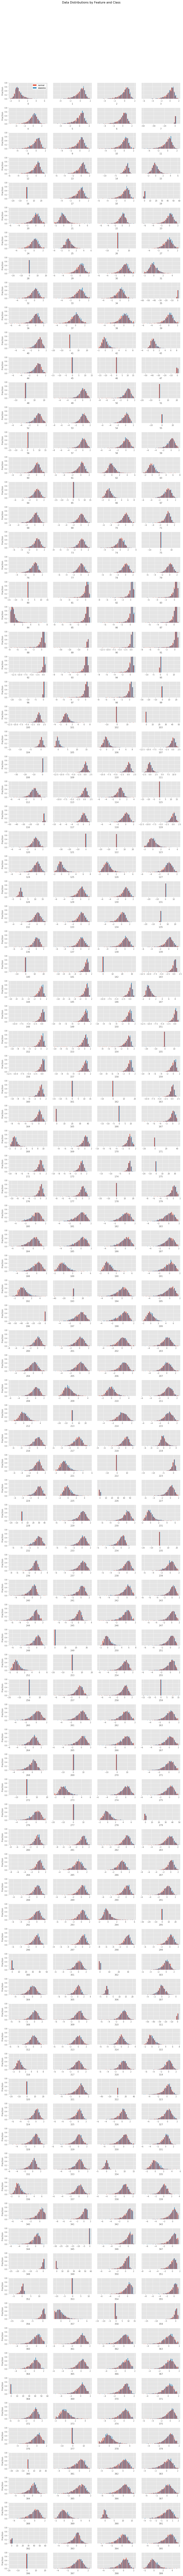

In [99]:
plot_data_distribution(data)

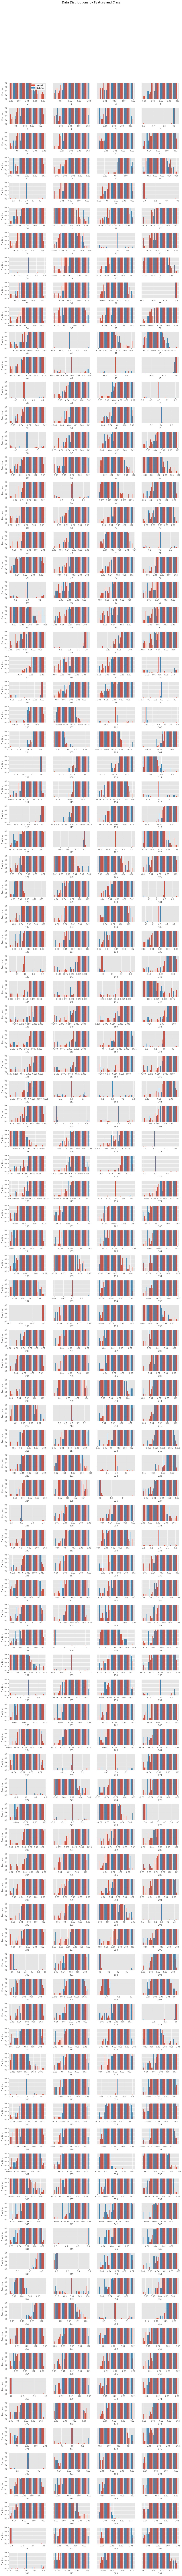

In [69]:
plot_data_distribution(train)

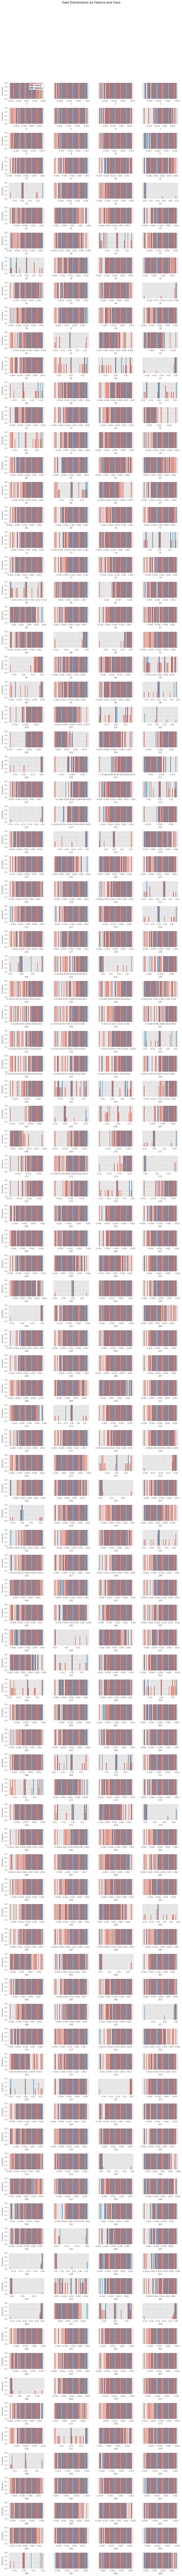

In [145]:
plot_data_distribution(x)

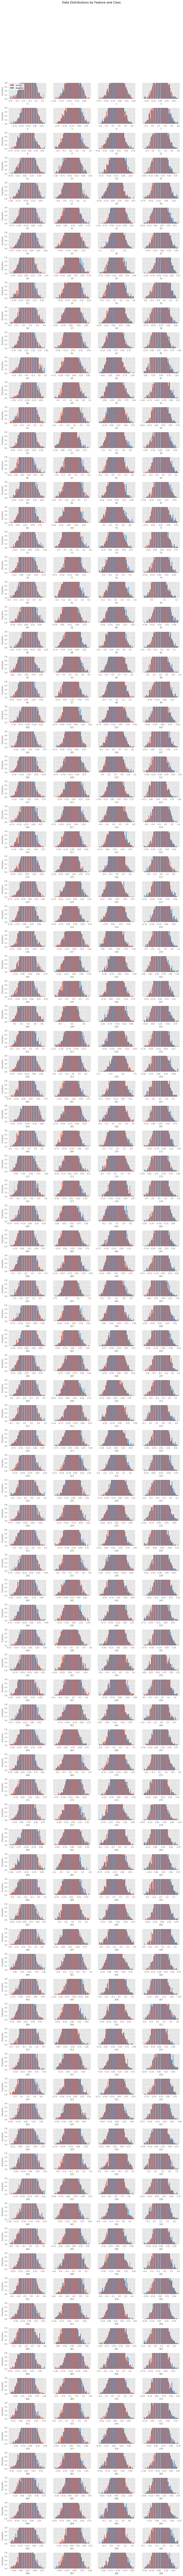

In [146]:
plot_data_distribution(g_z)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_114 (InputLayer)       (None, 400)               0         
_________________________________________________________________
dense_338 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_100 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_339 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_340 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 2700 samples, validate on 300 samples
Epoch 1/10
2592/2700 [===========================>..] - ETA: 0s - loss: 0.6369 - auc: 0.5

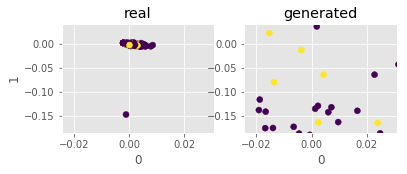

In [147]:

print( CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) )

PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )

In [148]:
# Now can train and test the classifier on generated data

real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
test_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
real_samples['syn_label'] = 0
test_samples['syn_label'] = 1

training_fraction = 0.5
n_real, n_test = int(len(real_samples)*training_fraction), int(len(test_samples)*training_fraction)
train_df = pd.concat([real_samples[:n_real],test_samples[:n_test]],axis=0)
test_df = pd.concat([real_samples[n_real:],test_samples[n_test:]],axis=0)

# X_col = test_df.columns[:-(label_dim+1)]
X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
#dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col])
#dtest = xgb.DMatrix(test_df[X_col])
y_true = test_df['syn_label']

base_n_count = 128
inputs = layers.Input((train_df.shape[1]-2,))
m = layers.Dense(base_n_count, activation='relu')(inputs)
m = layers.Dropout(0.3)(m)
m = layers.Dense(base_n_count*4, activation='relu')(m)
#x = layers.Dropout(0.2)(x)
#x = layers.Dense(base_n_count*8, activation='relu')(x)
#x = layers.Dense(base_n_count*4, activation='relu')(x)
#x = layers.Dense(base_n_count*2, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
#x = layers.Dense(base_n_count, activation='relu')(x)
m = layers.Dense(1, activation='sigmoid')(m)
#x = layers.Dense(1)(x)
classify_model = models.Model(inputs=[inputs], outputs=[m], name='classification_model')
adadelta = optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=None, decay=0.01)
classify_model.compile(optimizer=adadelta, loss='binary_crossentropy', metrics=[auc])
classify_model.summary()

earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('model-nn-classify-after.h5', verbose=1, save_best_only=True)

X_train = train_df.values[:,:400]
y_train = train_df.values[:,400]
X_test = test_df.values[:,:400]
y_test = test_df.values[:,400]

results = classify_model.fit(X_train, y_train, validation_split=0.1, batch_size=32, epochs=100,
                    callbacks=[earlystopper, checkpointer])

model = models.load_model('model-nn-classify-after.h5', custom_objects={'auc': auc})

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_115 (InputLayer)       (None, 400)               0         
_________________________________________________________________
dense_341 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_101 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_342 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_343 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2560/2700 [===========================>..] - ETA: 0s - loss: 0.6379 - auc: 0.

2560/2700 [===========================>..] - ETA: 0s - loss: 0.5479 - auc: 0.5258
Epoch 00051: val_loss improved from 0.58003 to 0.57996, saving model to model-nn-classify-after.h5
2700/2700 [==============================] - 1s 240us/step - loss: 0.5509 - auc: 0.5258 - val_loss: 0.5800 - val_auc: 0.5259
Epoch 52/100
2560/2700 [===========================>..] - ETA: 0s - loss: 0.5527 - auc: 0.5261
Epoch 00052: val_loss improved from 0.57996 to 0.57995, saving model to model-nn-classify-after.h5
2700/2700 [==============================] - 1s 237us/step - loss: 0.5508 - auc: 0.5261 - val_loss: 0.5799 - val_auc: 0.5263
Epoch 53/100
2592/2700 [===========================>..] - ETA: 0s - loss: 0.5530 - auc: 0.5264
Epoch 00053: val_loss improved from 0.57995 to 0.57994, saving model to model-nn-classify-after.h5
2700/2700 [==============================] - 1s 238us/step - loss: 0.5507 - auc: 0.5264 - val_loss: 0.5799 - val_auc: 0.5266
Epoch 54/100
2592/2700 [===========================>..] 

Epoch 78/100
2688/2700 [============================>.] - ETA: 0s - loss: 0.5486 - auc: 0.5346
Epoch 00078: val_loss improved from 0.57942 to 0.57940, saving model to model-nn-classify-after.h5
2700/2700 [==============================] - 1s 292us/step - loss: 0.5487 - auc: 0.5346 - val_loss: 0.5794 - val_auc: 0.5347
Epoch 79/100
2688/2700 [============================>.] - ETA: 0s - loss: 0.5490 - auc: 0.5349
Epoch 00079: val_loss improved from 0.57940 to 0.57938, saving model to model-nn-classify-after.h5
2700/2700 [==============================] - 1s 340us/step - loss: 0.5487 - auc: 0.5349 - val_loss: 0.5794 - val_auc: 0.5350
Epoch 80/100
2624/2700 [============================>.] - ETA: 0s - loss: 0.5477 - auc: 0.5351
Epoch 00080: val_loss did not improve
2700/2700 [==============================] - 1s 294us/step - loss: 0.5486 - auc: 0.5351 - val_loss: 0.5794 - val_auc: 0.5353
Epoch 81/100
2624/2700 [============================>.] - ETA: 0s - loss: 0.5496 - auc: 0.5355
Epoch 000

In [149]:
print( '{:.2f}'.format(SimpleAccuracy(preds_train_t, y_train[:int(y_train.shape[0]*0.9)])) )
print( '{:.2f}'.format(SimpleAccuracy(preds_val_t, y_train[int(y_train.shape[0]*0.9):])) )
print( '{:.2f}'.format(SimpleAccuracy(preds_test_t, y_test)) )

0.76
0.74
0.75


In [140]:
unique, counts = np.unique(y_test[:int(y_test.shape[0]*0.9)], return_counts=True)
dict(zip(unique, counts))

{0.0: 639, 1.0: 207}

In [141]:
unique, counts = np.unique(preds_test_t, return_counts=True)
dict(zip(unique, counts))

{0: 940}

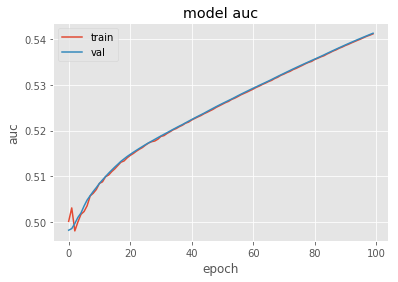

In [150]:
plt.plot(results.history['auc'])
plt.plot(results.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

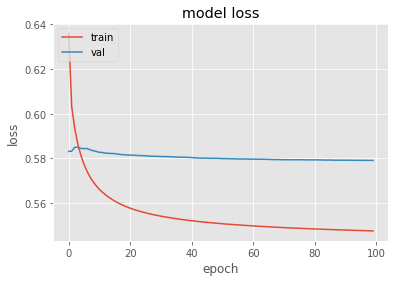

In [151]:
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [152]:
print(np.mean(preds_train_t == y_train[:int(y_train.shape[0]*0.9)]))
print(np.mean(preds_val_t == y_train[int(y_train.shape[0]*0.9):]))
print(np.mean(preds_test_t == y_test))

0.7555555555555555
0.74
0.748


In [155]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
auc_test = auc(fpr, tpr)
print(auc_test)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train[:int(y_train.shape[0]*0.9)], preds_train)
auc_train = auc(fpr_train, tpr_train)
print(auc_train)
TP, TN, FP, FN = BaseMetrics(preds_test_t, y_test)
print("precision =", TP/(TP+FP))
print("recall = ", TP/(TP+FN))

0.5073508780616623
0.5890132947118242
precision = nan
recall =  0.0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
